## 6 - 28.11.25

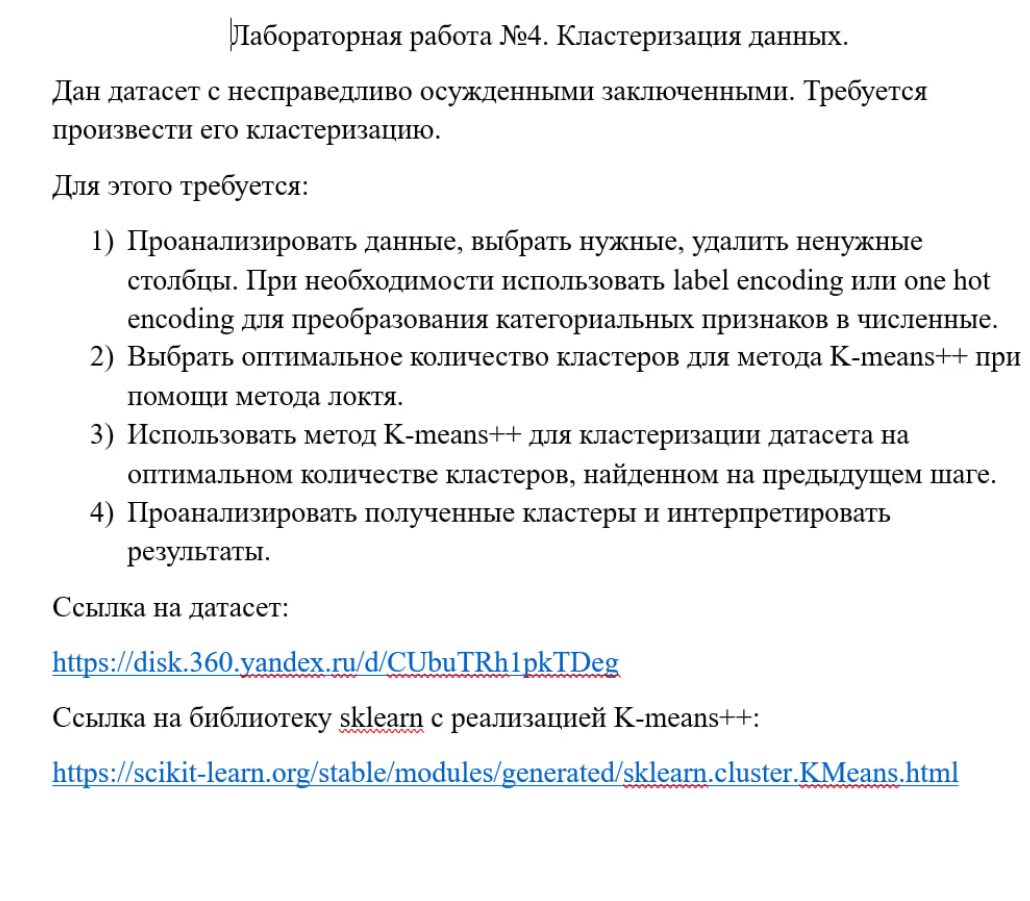

In [277]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as ppc
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

In [278]:
data = pd.read_csv("./data/wrong_conv_in_us.csv")

In [279]:
df = data.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          178 non-null    int64 
 1   Date of the Crime           178 non-null    int64 
 2   Defendants                  178 non-null    object
 3   Type of the Crime           178 non-null    object
 4   Location of the Crime       178 non-null    object
 5   Punishment for a crime      169 non-null    object
 6   Legally Exonerated          178 non-null    object
 7   Legally Exonerated Encoded  178 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 11.3+ KB


In [280]:
df.head(5)

,ID,Date of the Crime,Defendants,Type of the Crime,Location of the Crime,Punishment for a crime,Legally Exonerated,Legally Exonerated Encoded
0,0,1805,Dominic Daley and James Halligan,murder,Massachusetts,death,yes,1
1,1,1843,John Gordon,murder,Rhode Island,death,yes,1
2,2,1855,Chief Leschi,murder,Washington,death,no,0
3,3,1863,Chipita Rodriguez,murder,Texas,death,yes,1
4,4,1872,William Jackson Marion,murder,Nebraska,death,yes,1


In [281]:
numeric_cols = df.select_dtypes(
    include=[
        "int64",
        "float64",
    ]
).columns.tolist()

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

numeric_cols, cat_cols

(['ID', 'Date of the Crime', 'Legally Exonerated Encoded'],
 ['Defendants',
  'Type of the Crime',
  'Location of the Crime',
  'Punishment for a crime',
  'Legally Exonerated'])

In [282]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", ppc.StandardScaler()),
        # (
        #     "transformer",
        #     ppc.SplineTransformer(
        #         n_knots=3,
        #         degree=3,
        #         order="F",
        #         extrapolation="linear",
        #     ),
        # ),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            ppc.OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=False,
            ),
        )
    ]
)

In [283]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [284]:
df_enc = preprocessor.fit_transform(df)

# df_enc = df_enc.toarray()

In [285]:
results = []
models = {}
k_values = list(range(2, 15))
metric = "sil"
SEED = 42

In [286]:
for k in k_values:
    km = KMeans(n_clusters=k, random_state=SEED, init="k-means++")
    km.fit(df_enc)
    labels = km.labels_

    sil = silhouette_score(df_enc, labels)
    cal = calinski_harabasz_score(df_enc, labels)
    dav = davies_bouldin_score(df_enc, labels)

    results.append(
        {
            "k": k,
            "wcss": km.inertia_,
            "sil": sil,
            "cal": cal,
            "dav": dav,
        }
    )
    models[k] = km

In [287]:
scores_df = pd.DataFrame(results)
display(scores_df)

,k,wcss,sil,cal,dav
0,2,964.328475,0.261951,41.819015,1.873352
1,3,769.397661,0.294748,48.226704,1.210112
2,4,669.089124,0.179015,45.455155,1.730255
3,5,655.591718,0.175111,35.483719,1.483690
4,6,621.789228,0.128258,31.627273,1.822172
5,7,600.277552,0.127269,28.163170,1.938367
6,8,594.178929,0.112599,24.494280,2.382819
7,9,588.257002,0.102017,21.733575,2.448434
8,10,583.015217,0.095374,19.544913,2.688750
9,11,573.001551,0.099156,18.083140,2.511916


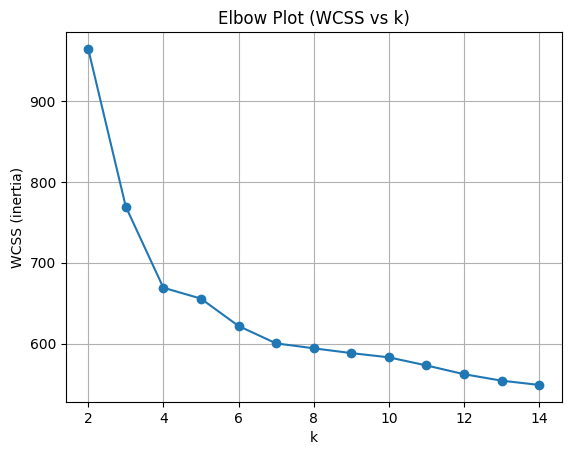

In [288]:
plt.figure()
plt.plot(scores_df["k"], scores_df["wcss"], marker="o")
plt.title("Elbow Plot (WCSS vs k)")
plt.xlabel("k")
plt.ylabel("WCSS (inertia)")
plt.grid(True)
plt.show()

с помощью метода локтя можно сказать, что оптимально брать k = 4

In [289]:
best_k_value = 4

best_model = models[best_k_value]
labels = best_model.labels_

df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    24
1    77
2    20
3    57
Name: count, dtype: int64


In [290]:
df_enc

array([[-1.72234737, -5.09225036,  0.40422604, ...,  0.        ,
         0.        ,  1.        ],
       [-1.70288581, -3.98912515,  0.40422604, ...,  0.        ,
         0.        ,  1.        ],
       [-1.68342426, -3.64076982, -2.47386338, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.68342426,  1.06202711,  0.40422604, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.70288581,  1.06202711,  0.40422604, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.72234737,  1.06202711,  0.40422604, ...,  0.        ,
         0.        ,  1.        ]], shape=(178, 309))

In [291]:
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1,
       1, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

In [292]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_enc)

fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=labels,
    title="Кластеры (PCA визуализация)",
    labels={
        "x": f"PC1 ({pca.explained_variance_ratio_[0]:.2%})",
        "y": f"PC2 ({pca.explained_variance_ratio_[1]:.2%})",
    },
)
fig.show()

In [296]:
df["label"] = labels

In [298]:
for cluster_id in range(best_k_value):
    cluster_data = df[df["label"] == cluster_id]
    print(f"Кластер {cluster_id}:")
    print(f"  Размер: {len(cluster_data)} образцов")
    print(f"  Средний год: {cluster_data['Date of the Crime'].mean():.0f}")
    print(
        f"  Всего реабилитирован (без ошибок): {(cluster_data['Legally Exonerated Encoded'] == 1).sum()}"
    )
    print()

Кластер 0:
  Размер: 24 образцов
  Средний год: 1985
  Всего реабилитирован (без ошибок): 0

Кластер 1:
  Размер: 77 образцов
  Средний год: 1982
  Всего реабилитирован (без ошибок): 77

Кластер 2:
  Размер: 20 образцов
  Средний год: 1896
  Всего реабилитирован (без ошибок): 19

Кластер 3:
  Размер: 57 образцов
  Средний год: 2006
  Всего реабилитирован (без ошибок): 57

